In [18]:
import os, sys
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import torch
from torchvision.models import alexnet, vgg19, inception_v3, resnet50
import timm
from torch.utils.data import Dataset, DataLoader
from thop import profile
from tool import trainer, imageDataset
torch.__version__

'1.10.1+cu113'

In [2]:
RANDOM_STATE = 111
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4
TEST_SIZE = 0.15

### 讀取資料

In [3]:
dir_path = './data/'
dir_list = ['normal', 'osteopenia', 'osteoporosis']

data_path, labels = [], []
for index, item in enumerate(dir_list):
    images = os.listdir(dir_path + item)
    for image in images:
        if image[0] != '.':
            data_path.append(dir_path + item + '/' + image)
            labels.append(index)

print(f'資料共{len(data_path)}筆')

資料共239筆


### 資料前處理

In [4]:
def data_preprocess(paths):
    features = []
    for path in tqdm(paths):
        # 讀取image，並轉為灰階影像
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))
        img = np.transpose(img, (2, 0, 1)).astype('float32')
        # 標準化(MaxAbs)，灰階影像最大為255
        img = img / 255
        features.append(img)
        
    return features

### OneHotEncoding

In [5]:
# 轉成np.array再轉成oneHotEncoding
def OneHotEncoding(labels):
    y = np.eye(3)[np.array(list(map(int, labels)))]
    return y

### 切分資料

In [6]:
%%time
X_train, X_valid, Y_train, Y_valid = train_test_split(data_path, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f'訓練資料共{len(X_train)}筆')
print(f'驗證資料共{len(X_valid)}筆')

訓練資料共203筆
驗證資料共36筆
CPU times: user 1.39 ms, sys: 286 µs, total: 1.68 ms
Wall time: 1.62 ms


### Data Preocess and set DataLoader

In [9]:
%%time
train_data = imageDataset(data_preprocess(X_train), OneHotEncoding(Y_train))
val_data = imageDataset(data_preprocess(X_valid), OneHotEncoding(Y_valid))

# set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# set the DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(val_data, batch_size=36, shuffle = False)

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 13.2 s, sys: 1.1 s, total: 14.3 s
Wall time: 14.3 s


# 各模型比較

### alexnet
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

--------------------Epoch 1--------------------
Train_accuracy: 56.16% | Train_loss: 12.5329
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 11.8624
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 11.4544
--------------------Epoch 4--------------------
Train_accuracy: 66.01% | Train_loss: 11.1416
--------------------Epoch 5--------------------
Train_accuracy: 65.02% | Train_loss: 11.0458
--------------------Epoch 6--------------------
Train_accuracy: 65.02% | Train_loss: 11.0676
--------------------Epoch 7--------------------
Train_accuracy: 65.02% | Train_loss: 10.6193
--------------------Epoch 8--------------------
Train_accuracy: 66.01% | Train_loss: 10.7030
--------------------Epoch 9--------------------
Train_accuracy: 65.52% | Train_loss: 10.5176
--------------------Epoch 10--------------------
Train_accuracy: 67.00% | Train_loss: 10.0851


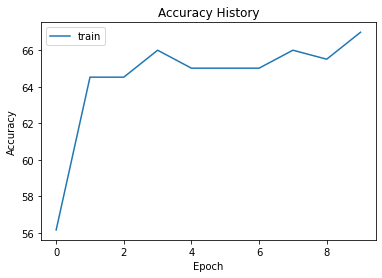

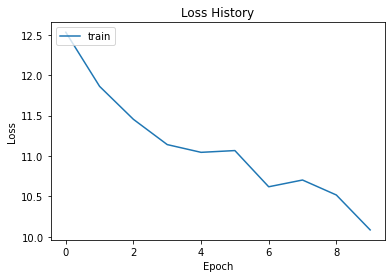

Accuracy on the test images: 63.89%
Inference time: 2.5733 milliseconds


In [20]:
# pre-trained model(https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet)
model = alexnet(pretrained=True).to(device)
# Modify the last layer(num_classes: 1000 => 3), Replace the last layer with a new fully connected layer with 3 output units(ChatGPT)
model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
alexnet_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-5)
# train process
alexnet_trainer.train()
alexnet_trainer.predict()

### VGG19
- https://pytorch.org/vision/0.11/models.html?highlight=vgg19#torchvision.models.vgg19

--------------------Epoch 1--------------------
Train_accuracy: 61.58% | Train_loss: 12.6233
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 11.8579
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 11.7626
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 11.4315
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 11.6228
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 11.4930
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 11.1611
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 10.9461
--------------------Epoch 9--------------------
Train_accuracy: 65.52% | Train_loss: 10.4962
--------------------Epoch 10--------------------
Train_accuracy: 68.47% | Train_loss: 10.0482


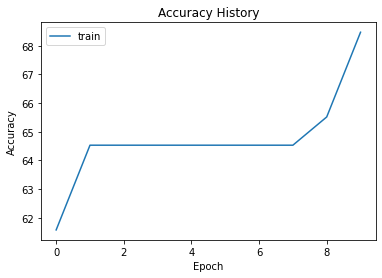

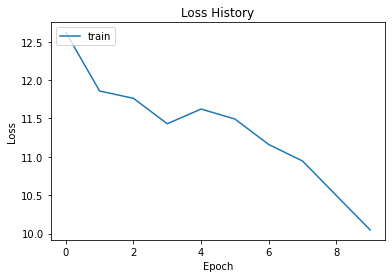

Accuracy on the test images: 66.67%
Inference time: 46.3923 milliseconds


In [11]:
model = vgg19(pretrained=True).to(device)
model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
vgg19_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-4)
vgg19_trainer.train()
vgg19_trainer.predict()

### resnet50
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

--------------------Epoch 1--------------------
Train_accuracy: 14.29% | Train_loss: 17.1232
--------------------Epoch 2--------------------
Train_accuracy: 14.78% | Train_loss: 15.3556
--------------------Epoch 3--------------------
Train_accuracy: 20.69% | Train_loss: 13.9483
--------------------Epoch 4--------------------
Train_accuracy: 40.39% | Train_loss: 12.6562
--------------------Epoch 5--------------------
Train_accuracy: 62.07% | Train_loss: 11.8374
--------------------Epoch 6--------------------
Train_accuracy: 75.37% | Train_loss: 10.5466
--------------------Epoch 7--------------------
Train_accuracy: 82.76% | Train_loss: 9.7440
--------------------Epoch 8--------------------
Train_accuracy: 90.64% | Train_loss: 8.6995
--------------------Epoch 9--------------------
Train_accuracy: 92.12% | Train_loss: 7.9118
--------------------Epoch 10--------------------
Train_accuracy: 94.09% | Train_loss: 7.2303


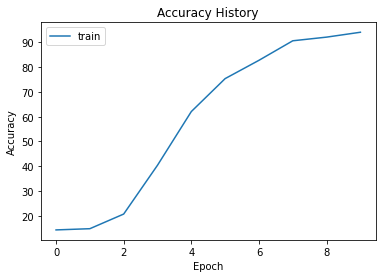

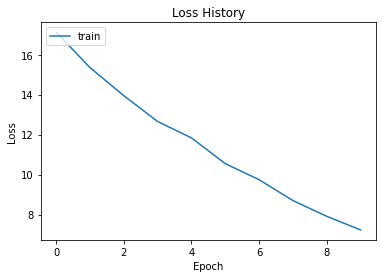

Accuracy on the test images: 50.00%
Inference time: 28.5583 milliseconds


In [24]:
model = resnet50(pretrained=True).to(device)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 3).to(device)

resnet_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-6)
resnet_trainer.train()
resnet_trainer.predict()

### inception_v4
- https://huggingface.co/docs/timm/models/inception-v4

--------------------Epoch 1--------------------
Train_accuracy: 18.72% | Train_loss: 16.1610
--------------------Epoch 2--------------------
Train_accuracy: 25.62% | Train_loss: 15.3588
--------------------Epoch 3--------------------
Train_accuracy: 33.99% | Train_loss: 14.5574
--------------------Epoch 4--------------------
Train_accuracy: 46.31% | Train_loss: 13.9013
--------------------Epoch 5--------------------
Train_accuracy: 50.25% | Train_loss: 13.4554
--------------------Epoch 6--------------------
Train_accuracy: 61.08% | Train_loss: 12.8096
--------------------Epoch 7--------------------
Train_accuracy: 65.52% | Train_loss: 12.3729
--------------------Epoch 8--------------------
Train_accuracy: 79.31% | Train_loss: 11.6712
--------------------Epoch 9--------------------
Train_accuracy: 80.79% | Train_loss: 11.1254
--------------------Epoch 10--------------------
Train_accuracy: 84.24% | Train_loss: 10.8760


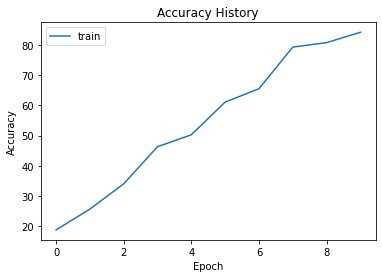

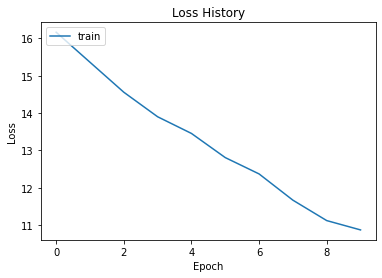

Accuracy on the test images: 55.56%
Inference time: 56.0026 milliseconds


In [25]:
model = timm.create_model('inception_v4', pretrained=True, num_classes=3).to(device)
inception_v4_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-6)
inception_v4_trainer.train()
inception_v4_trainer.predict()

### Visual Transformer

--------------------Epoch 1--------------------
Train_accuracy: 51.23% | Train_loss: 37.9234
--------------------Epoch 2--------------------
Train_accuracy: 57.14% | Train_loss: 12.9890
--------------------Epoch 3--------------------
Train_accuracy: 57.64% | Train_loss: 13.1510
--------------------Epoch 4--------------------
Train_accuracy: 61.58% | Train_loss: 12.6153
--------------------Epoch 5--------------------
Train_accuracy: 61.08% | Train_loss: 12.7265
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 11.7534
--------------------Epoch 7--------------------
Train_accuracy: 61.58% | Train_loss: 13.4855
--------------------Epoch 8--------------------
Train_accuracy: 58.13% | Train_loss: 12.6230
--------------------Epoch 9--------------------
Train_accuracy: 55.67% | Train_loss: 13.1955
--------------------Epoch 10--------------------
Train_accuracy: 66.50% | Train_loss: 11.8317


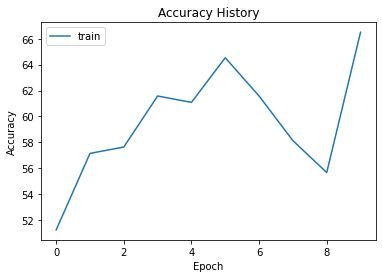

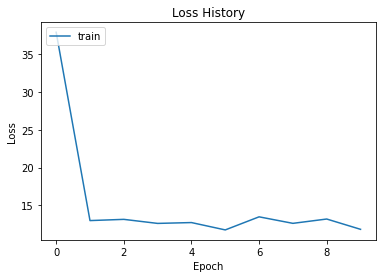

Accuracy on the test images: 63.89%
Inference time: 51.7601 milliseconds


In [15]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=3).to(device)
vit_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-4)
vit_trainer.train()
vit_trainer.predict()

### Swin-Transformer
- https://github.com/microsoft/Swin-Transformer

--------------------Epoch 1--------------------
Train_accuracy: 59.11% | Train_loss: 12.2325
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 11.7971
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 11.5816
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 11.4574
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 11.3753
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 11.2356
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 11.1163
--------------------Epoch 8--------------------
Train_accuracy: 65.52% | Train_loss: 10.3045
--------------------Epoch 9--------------------
Train_accuracy: 73.40% | Train_loss: 9.3476
--------------------Epoch 10--------------------
Train_accuracy: 64.53% | Train_loss: 11.4315


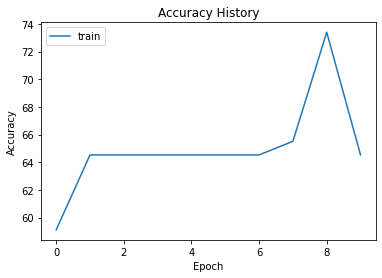

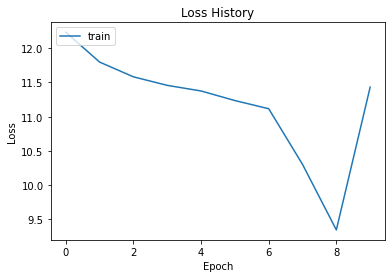

Accuracy on the test images: 63.89%
Inference time: 95.8750 milliseconds


In [26]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=3).to(device)
swin_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-5)
swin_trainer.train()
swin_trainer.predict()